# Import data

The data can be obtained from the Kaggle competition, and is in JSON format

In [1]:
import pandas as pd
import numpy as np

df = pd.read_json('./data/train.json')
df.head(10)

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli..."
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por..."
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [2]:
df.shape

(39774, 3)

# Data engineering

I will add columns for ingredient counts and flatten the ingredients array one-hot style.

Unfortunately due to the format of `df['ingredients']` I can't use the OneHotEncoder directly. I'll simulate it with a couple for loops.

First I need those counts, which is easy enough

In [3]:
df['count_ingredients'] = df['ingredients'].map(lambda ingredients: len(ingredients))
df.head(10)

,id,cuisine,ingredients,count_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...",12
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...",13
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...",10
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...",13
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-...",6


Now I need to simulate the OneHotEncoder.

There is probably a faster and more efficient way to do this, but not that are obvious to me.

First I need to get the ingredients. I'll put them into a `set` to ensure uniqueness, and simply iterate through all the ingredients arrays.

In [4]:
flattened_native = set()
for ary in df['ingredients']:
    flattened_native = flattened_native.union(ary)

len(flattened_native)

6714

Now that I have all the ingredients in a set, I can create columns for them in the dataframe.

Once more, there is probably a faster way to do this. I am looping through all 6714 ingredients and inserting 1 or 0 if they appear in each row's ingredients list, using the map function

Once that's done I can drop the ingredients column

In [5]:
for ingredient in flattened_native:
    df[ingredient] = df['ingredients'].map(lambda ingredients: int(ingredient in ingredients))

df.head(10)

,id,cuisine,ingredients,count_ingredients,membrillo,thai jasmine rice,red russian kale,chowchow,navy beans,pink grapefruit juice,...,dried dates,red chili powder,dried red chile peppers,low-fat flour tortillas,bolillo,Pam Cooking Spray,medium firm tofu,candlenuts,bee pollen,beaten eggs
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...",12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...",13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...",10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...",13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-...",6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
del df['ingredients']
df.shape

(39774, 6717)

Before I do anything else, I'll split off the target dataset, and split test from train.

In [7]:
X = df.copy()
y = df['cuisine']

del X['cuisine']

In [8]:
X_train = X[:30000]
X_test = X[30000:]
y_train = y[:30000]
y_test = y[30000:]

# Training

I have a hunch that a decision tree will work well on this, because typically many ingredients are unique to a culture or a group of cultures.

I can see it falling apart for more simple dishes which only have one or two very common ingredients. For those types of dishes (such as the Indian dish with 4 ingredients in the head above), I doubt it is possible to predict what kind of cuisine they are by ingredients alone.

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

cross_val_score(dt, X_train, y_train, cv=3, scoring="accuracy")

array([0.56740282, 0.57455746, 0.56814088])

That's pretty bad. Maybe if I change from a single tree to a forest it will get better!

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [12]:
cross_val_score(rf, X_train, y_train, cv=3, scoring="accuracy")

array([0.69211552, 0.69916992, 0.68681209])

Progress! What hyperparameters can I tune?

In [15]:
rf_params = [
    {'max_depth': [None, 2, 4, 8, 16, 32]},
    {'min_samples_leaf': [1, 2, 4, 8]}
]

Looks good! How does that work out...

In [16]:
from sklearn.model_selection import GridSearchCV

rf_cv = GridSearchCV(estimator=rf, param_grid=rf_params, cv=4)
rf_cv.fit(X_train, y_train) 

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_

In [17]:
cross_val_score(rf_cv.best_estimator_, X_train, y_train, cv=3, scoring='accuracy')

array([0.69211552, 0.69916992, 0.68681209])

That's disappointing.

In [26]:
importances = rf_cv.best_estimator_.feature_importances_

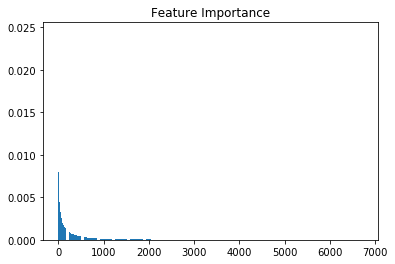

In [27]:
import matplotlib.pyplot as plt

indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])

plt.show()


In [38]:
for i in range(25):
    print(f'{names[indices[i]]} => {importances[indices[i]]}')

id => 0.024385539072433328
count_ingredients => 0.0224993610527031
unsalted roasted pistachios => 0.010524387146002517
blackening seasoning => 0.010203155294356227
Texas toast bread => 0.009566917684439223
fresh lime juice => 0.007996075339830213
cream cheese frosting => 0.007982766926614692
nam prik => 0.007964631763344079
Kraft Shredded Pepper Jack Cheese => 0.007270306592901606
rajma => 0.007228924881328892
Elmlea single => 0.00702488226277944
parmagiano reggiano => 0.00662383752932043
grill seasoning => 0.006582662134199604
endive => 0.006383734381780767
grit quick => 0.006361551925265075
breadcrumb mix => 0.006225590082483555
bulgur wheat => 0.005956177183097052
fresh chicken stock => 0.005839958101314664
sandwich steak => 0.005639309892337463
ground pepper => 0.0054900338955786235
Gochujang base => 0.005284267127329546
Korean chile flakes => 0.005281113935280291
pears => 0.005158125785371911
brine cured green olives => 0.004879678357230796
tomato ketchup => 0.004813827740882503
